In [2]:
import numpy as np
import matplotlib.pyplot as plt
import brainpy as bp
import brainpy.math as bm

bm.set_platform('cpu')

In [3]:
plt_style = {
    'figure.autolayout' : True,
    'font.size' : 24,
    'lines.linewidth' : 2,
    # 'xtick.labelsize' : 'medium',
    # 'ytick.labelsize' : 'medium',
        'xtick.labelsize' : 'medium',
    'ytick.labelsize' : 'medium',
    'legend.fontsize' : 'medium',
    'axes.spines.top' : True,
    'axes.spines.right' : True,
    'xtick.major.size' : 5,
    'ytick.major.size' : 5,
    'legend.fontsize' : 24,
    'axes.labelsize' : 24,
    'axes.titlesize' : 24,
    }
for key, val in plt_style.items():
    plt.rcParams[key] = val

Defining a neuron model in BrainPy is simple. You just need to inherit from ``brainpy.dyn.NeuDyn``, and satisfy the following two requirements:

- Providing the `size` of the neural group in the constructor when initialize a new neural group class. `size` can be a integer referring to the number of neurons or a tuple/list of integers referring to the geometry of the neural group in different dimensions. According to the provided group ``size``, ``brainpy.dyn.NeuDyn`` will automatically calculate the total number ``num`` of neurons in this group.

- Creating an `update()` function. Update function provides the rule how the neuron states are evolved from the current time $t$ to the next time $t+dt$.

In the following part, a [Hodgkin-Huxley](https://brainpy.readthedocs.io/en/latest/apis/generated/brainpy.dyn.HH.html) (HH) model is used as an example for illustration.

## [Hodgkin–Huxley Model](https://brainpy.readthedocs.io/en/latest/apis/generated/brainpy.dyn.HH.html)

The Hodgkin-Huxley (HH) model is a continuous-time dynamical system. It is one of the most successful mathematical models of a complex biological process that has ever been formulated. Changes of the membrane potential influence the conductance of different channels, elaborately modeling the neural activities in biological systems. Mathematically, the model is given by:

$$
\begin{aligned}
    C_m \frac {dV} {dt} &= -(\bar{g}_{Na} m^3 h (V -E_{Na})
    + \bar{g}_K n^4 (V-E_K) + g_{leak} (V - E_{leak})) + I(t) \quad\quad(1) \\
    \frac {dx} {dt} &= \alpha_x (1-x)  - \beta_x, \quad x\in {\rm{\{m, h, n\}}} \quad\quad(2) \\
    &\alpha_m(V) = \frac {0.1(V+40)}{1-\exp(\frac{-(V + 40)} {10})} \quad\quad(3) \\
    &\beta_m(V) = 4.0 \exp(\frac{-(V + 65)} {18}) \quad\quad(4) \\
    &\alpha_h(V) = 0.07 \exp(\frac{-(V+65)}{20}) \quad\quad(5) \\
    &\beta_h(V) = \frac 1 {1 + \exp(\frac{-(V + 35)} {10})} \quad\quad(6) \\
    &\alpha_n(V) = \frac {0.01(V+55)}{1-\exp(-(V+55)/10)} \quad\quad(7) \\
    &\beta_n(V) = 0.125 \exp(\frac{-(V + 65)} {80}) \quad\quad(8) \\
\end{aligned}
$$

where $V$ is the membrane potential, $C_m$ is the membrane capacitance per unit area, $E_K$ and $E_{Na}$ are the potassium and sodium reversal potentials, respectively, $E_l$ is the leak reversal potential, $\bar{g}_K$ and $\bar{g}_{Na}$ are the potassium and sodium conductance per unit area, respectively, and $\bar{g}_l$ is the leak conductance per unit area. Because the potassium and sodium channels are voltage-sensitive, according to the biological experiments, $m$, $n$ and $h$ are used to simulate the activation of the channels. Specially, $n$ measures the activation of potassium channels, and $m$  and $h$ measures the activation and inactivation of sodium channels, respectively. $\alpha_{x}$ and $\beta_{x}$ are rate constants for the ion channel x and depend exclusively on the membrane potential.

To implement the HH model, variables should be specified. According to the above equations, the following state variables change with respect to time:
- `V`: the membrane potential
- `m`: the activation of sodium channels
- `h`: the inactivation of sodium channels
- `n`: the activation of potassium channels

Besides, the spiking state and the last spiking time can also be recorded for statistic analysis:
- ``spike``: whether a spike is produced
- ``t_last_spike``: the last spiking time

Based on these state variables, the HH model can be implemented as below.

In [4]:
class HH(bp.dyn.NeuDyn):
  def __init__(self, size, ENa=50., gNa=120., EK=-77., gK=36., EL=-54.387, gL=0.03,
               V_th=20., C=1.0, **kwargs):
    # providing the group "size" information
    super(HH, self).__init__(size=size, **kwargs)

    # initialize parameters
    self.ENa = ENa
    self.EK = EK
    self.EL = EL
    self.gNa = gNa
    self.gK = gK
    self.gL = gL
    self.C = C
    self.V_th = V_th

    # initialize variables
    self.V = bm.Variable(bm.random.randn(self.num) - 70.)
    self.m = bm.Variable(0.0266 * bm.ones(self.num))
    self.h = bm.Variable(0.772 * bm.ones(self.num))
    self.n = bm.Variable(0.235 * bm.ones(self.num))
    self.spike = bm.Variable(bm.zeros(self.num, dtype=bool))
    self.t_last_spike = bm.Variable(bm.ones(self.num) * -1e7)

    # Define differential equations using integral functions
    self.int_V = bp.odeint(f=self.dV, method='exp_auto')
    self.int_m = bp.odeint(f=self.dm, method='exp_auto')
    self.int_h = bp.odeint(f=self.dh, method='exp_auto')
    self.int_n = bp.odeint(f=self.dn, method='exp_auto')

  def dV(self, V, t, m, h, n, Iext):
    I_Na = (self.gNa * m ** 3.0 * h) * (V - self.ENa)
    I_K = (self.gK * n ** 4.0) * (V - self.EK)
    I_leak = self.gL * (V - self.EL)
    dVdt = (- I_Na - I_K - I_leak + Iext) / self.C
    return dVdt

  def dm(self, m, t, V):
    alpha = 0.1 * (V + 40) / (1 - bm.exp(-(V + 40) / 10))
    beta = 4.0 * bm.exp(-(V + 65) / 18)
    dmdt = alpha * (1 - m) - beta * m
    return dmdt
  
  def dh(self, h, t, V):
    alpha = 0.07 * bm.exp(-(V + 65) / 20.)
    beta = 1 / (1 + bm.exp(-(V + 35) / 10))
    dhdt = alpha * (1 - h) - beta * h
    return dhdt

  def dn(self, n, t, V):
    alpha = 0.01 * (V + 55) / (1 - bm.exp(-(V + 55) / 10))
    beta = 0.125 * bm.exp(-(V + 65) / 80)
    dndt = alpha * (1 - n) - beta * n
    return dndt

  def update(self, x=None):
    _t = bp.share['t']
    _dt = bp.share['dt']
    x = 0. if x is None else x
    
    # compute V, m, h, n
    V            = self.int_V(self.V, _t, self.m, self.h, self.n, x, dt=_dt)
    self.h.value = self.int_h(self.h, _t, self.V, dt=_dt)
    self.m.value = self.int_m(self.m, _t, self.V, dt=_dt)
    self.n.value = self.int_n(self.n, _t, self.V, dt=_dt)

    # update the spiking state and the last spiking time
    self.spike.value = bm.logical_and(self.V < self.V_th, V >= self.V_th)
    self.t_last_spike.value = bm.where(self.spike, _t, self.t_last_spike)

    # update V
    self.V.value = V

In [5]:
current, length = bp.inputs.section_input(values=[0., bm.asarray([1., 2., 4., 8., 10., 15]), 0.], durations=[10,2,25], return_length=True)
hh_neurons = HH(current.shape[1])
runner = bp.DSRunner(hh_neurons, monitors=['V', 'm', 'h', 'n'])
runner.run(inputs=current)

  0%|          | 0/370 [00:00<?, ?it/s]

Text(0.5, 0, 'Time (ms)')

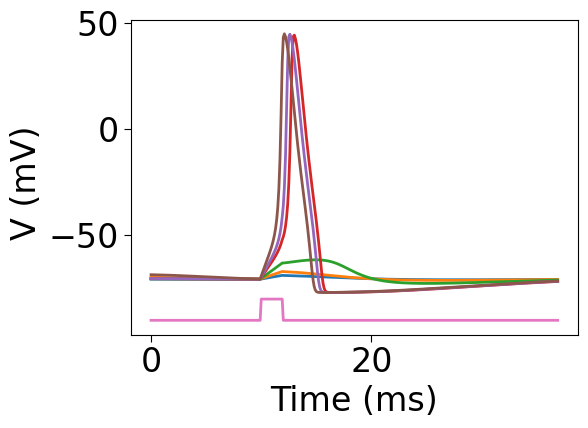

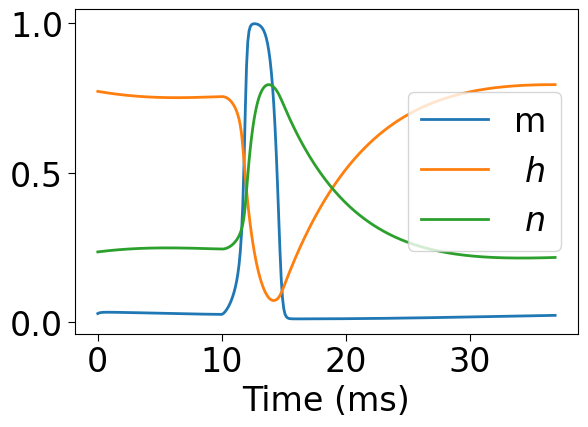

In [6]:
import matplotlib.pyplot as plt
bp.visualize.line_plot(runner.mon.ts, runner.mon.V, ylabel='V (mV) ', plot_ids=np.arange(current.shape[1]))
plt.plot(runner.mon.ts, bm.where(current[:,-1]>0,10,0) -90.)
plt.figure()
plt.plot(runner.mon.ts, runner.mon.m[:, -1])
plt.plot(runner.mon.ts, runner.mon.h[:, -1])
plt.plot(runner.mon.ts, runner.mon.n[:, -1])
plt. legend (['m', ' $h$ ', ' $n$ '])
plt.xlabel('Time (ms)')

In [7]:
current_2, length = bp.inputs.section_input(values=[0., 15. , 0.], durations=[2,200,2], return_length=True)
hh_neurons_2 = HH(1)
runner = bp.DSRunner(hh_neurons_2, monitors=['V', 'm', 'h', 'n'])
runner.run(inputs=current_2)

  0%|          | 0/2040 [00:00<?, ?it/s]

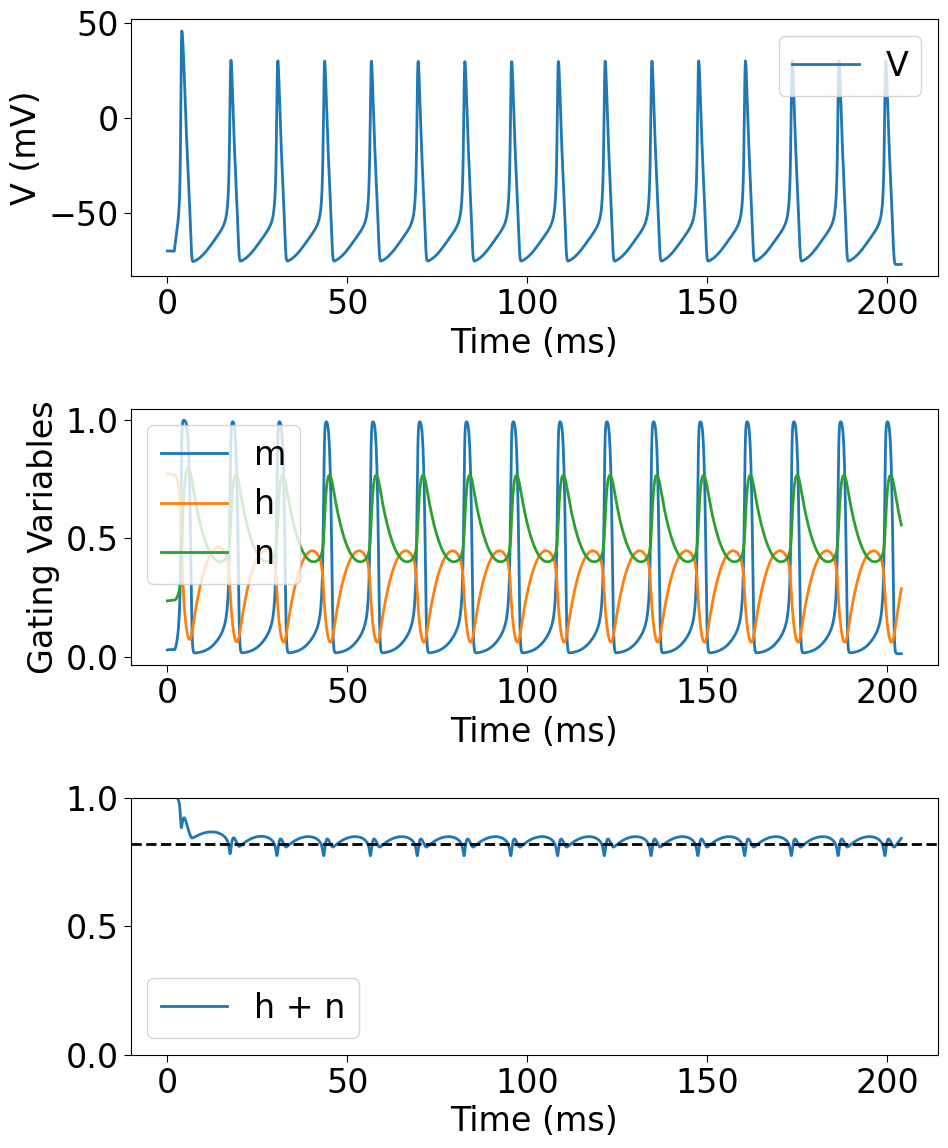

In [10]:
# Create a figure and a set of subplots
fig, axs = plt.subplots(3, 1, figsize=(10, 12))  # 3 rows, 1 column

# First plot
axs[0].plot(runner.mon.ts, runner.mon.V, label='V')
axs[0].set_xlabel('Time (ms)')
axs[0].set_ylabel('V (mV)')
axs[0].legend()

# Second plot
axs[1].plot(runner.mon.ts, runner.mon.m, label='m')
axs[1].plot(runner.mon.ts, runner.mon.h, label='h')
axs[1].plot(runner.mon.ts, runner.mon.n, label='n')
axs[1].set_xlabel('Time (ms)')
axs[1].set_ylabel('Gating Variables')
axs[1].legend()

# Third plot
axs[2].plot(runner.mon.ts, runner.mon.h + runner.mon.n, label='h + n')
axs[2].set_xlabel('Time (ms)')
axs[2].set_ylim([0, 1])
axs[2].set_yticks([0, 0.5, 1])
axs[2].axhline(y=0.82, color='k', linewidth=2, linestyle='--')
axs[2].legend()

# Adjust layout to prevent overlap
fig.tight_layout()

# Show the plot
plt.show()


# Examples of using built-in models

In [10]:
Hodgkin_Huxley_model = bp.dyn.HH(size=3, gNa= bp.init.Uniform(min_val=100, max_val=140)) 

  0%|          | 0/1000 [00:00<?, ?it/s]

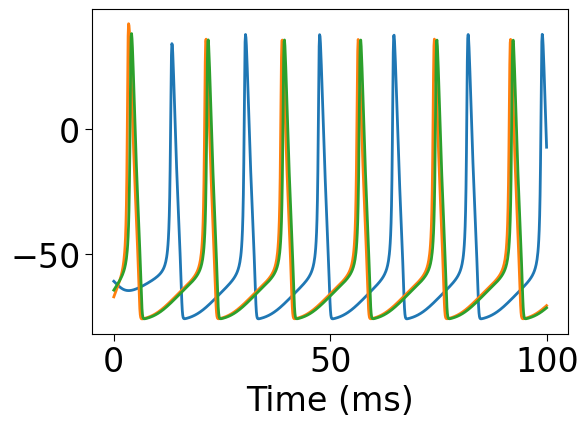

In [11]:
inputs = np.ones(int(100./ bm.dt)) * 6.  # 100 ms
runner = bp.DSRunner(Hodgkin_Huxley_model, monitors=['V'])
runner.run(inputs=inputs)

bp.visualize.line_plot(runner.mon.ts, runner.mon.V, plot_ids=[0, 1, 2], show=True)